In [104]:
import scipy
from scipy import ndimage as ndi
from skimage import measure
from skimage import data
from skimage import filters
from skimage import feature
import matplotlib.pyplot as plt
import numpy as np
from __future__ import division
import itertools
from matplotlib.pyplot import imshow

In [105]:
%matplotlib inline

In [355]:
# target_yellow = np.array([255, 202, 80])#np.array([199, 159, 50])
# target_green = np.array([2, 123, 3])#([36, 64, 33])
# target_blue = np.array([6, 159, 211])#np.array([16, 64, 122])
target_yellow = np.array([199, 159, 50])
target_green = np.array([36, 64, 33])
target_blue = np.array([16, 64, 122])
norm_yellow = target_yellow / target_yellow[0]
norm_green = target_green / target_green[0]
norm_blue = target_blue / target_blue[0]
norms = [norm_yellow, norm_green, norm_blue]
targets = [target_yellow, target_green, target_blue]

In [356]:
hue = np.array([1,1,1])

In [361]:
img_orig = ndi.imread("./stalk11.jpg")
new = np.array(img_orig[:,:]*hue, dtype="uint8")
img = new

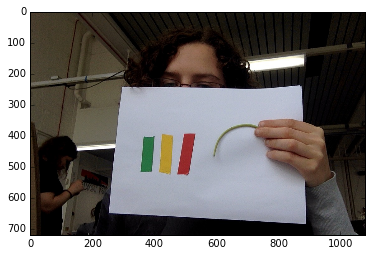

In [362]:
imshow(img_orig)

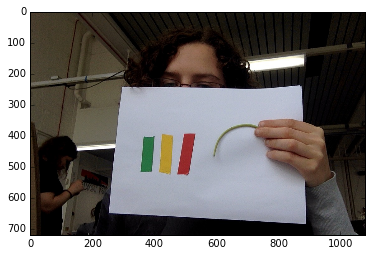

In [363]:
imshow(img)

In [364]:
# ar,ag,ab = np.mean(img[:,:,0]),np.mean(img[:,:,1]),np.mean(img[:,:,2])
# print ar/ag, ar/ab
# level = np.mean([ar, ag, ab])
# if level < 90:
#     bright = [90 - level for i in range(3)]
#     img = np.array(img[:,:]+bright, dtype="uint8")

In [365]:
im = filters.gaussian_filter(img, sigma=256 / (40. * 20))

/Users/admin/miniconda2/lib/python2.7/site-packages/skimage/filters/_gaussian.py:13: skimage_deprecation: Call to deprecated function ``gaussian_filter``. Use ``skimage.filters.gaussian`` instead.
  multichannel=None):


In [366]:
blobs = im < im.mean()
red_blobs = blobs[:,:,0][:,:,None]
blue_blobs = blobs[:,:,2][:,:,None]

In [367]:
def score_colours(feats):
    avgs = [np.array((np.mean(ft[:,:,0]),np.mean(ft[:,:,1]),np.mean(ft[:,:,2]))) for ft in feats]
    norm_colours = [c/c[0] for c in avgs]
    order = list(itertools.permutations([norm_yellow,norm_green,norm_blue]))
    scores = np.array([np.sum(np.array((np.array(norm_colours) - np.array(targets))**2)) for targets in order])
    return (order[np.argmin(scores)], np.min(scores))

In [368]:
def find_colours_grass(feats):
    all_scores = []
    for blocks, i in zip(list(itertools.combinations(feats, 3)), list(itertools.combinations(range(len(feats)), 3))):
        all_scores.append((blocks,score_colours(blocks)[1],i))
    print np.array(feats).shape
    minscore = np.min(np.array(all_scores)[:,1])
    blocks = None
    for b, score, i in all_scores:
        if score == minscore:
            blocks = b
            blocksi = i
    grassi = [a for a in range(len(feats)) if not a in blocksi][0]
    grass = feats[grassi]
    return (blocks, grass)

In [369]:
def get_targets(ntargets):
    result = []
    for t in ntargets[0]:
        for i,n in enumerate(norms):
#             if all(n == t):
            if np.array_equal(n,t):
                result.append(targets[i])
                break
    return result

In [370]:
def get_diffs(feats, ntargets):
    avgs = [np.array((np.mean(ft[:,:,0]),np.mean(ft[:,:,1]),np.mean(ft[:,:,2]))) for ft in feats]
    target_colours = get_targets(ntargets)
    return np.array(avgs) - np.array(target_colours)

In [371]:
def get_total_diffs(feats, ntargets):
    diffs = get_diffs(feats, ntargets)
    return np.array([np.mean(diffs[:,i]) for i in range(3)])

(4, 720, 1080, 3)


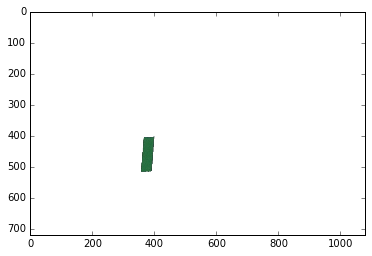

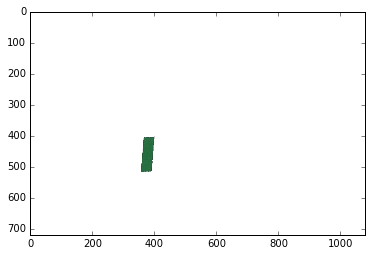

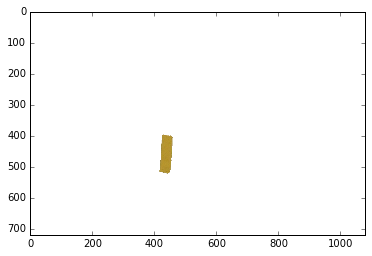

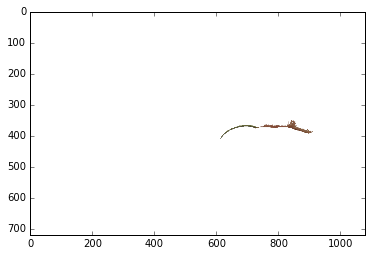

[ 0.01542654  0.0967368  -0.03204773]


In [376]:
features = []
for blobs in [red_blobs, blue_blobs]:
    all_labels, n = measure.label(blobs, return_num=True)
    for i in range(n):
        blob = np.ma.masked_where(all_labels != i, all_labels)
        m = np.repeat(blob.mask,3,axis=2)
        ft = np.ma.masked_array(img, mask=m)
        ft.fill_value = 255
        avr,avg,avb = np.mean(ft[:,:,0]),np.mean(ft[:,:,1]),np.mean(ft[:,:,2])
        colour = np.array([avr,avg,avb])
        norm_colour = colour / colour[0]
#         avgs = np.sort([avr,avb,avg])
#         def_colour = avgs[-1] / (avgs[0]+avgs[1]) > 0.9
#         max_std = np.max([np.std(ft[:,:,0]),np.std(ft[:,:,1]),np.std(ft[:,:,2])])
        score = (avr/avg) / (avr/avb)
        score = score if score > 1 else 1/score
#         if def_colour and ft.count() > 3000 and max_std < 30 and score > 1.5:
        if ft.count() > 3000 and ft.count() < 50000 and score > 1.1:
            features.append((ft, score))
            
features = sorted(features, key=lambda x: x[1])[:4]
features = [f[0] for f in features]
features, grass = find_colours_grass(features)
for ft in features:
    imshow(ft.filled())
    plt.show()
imshow(grass.filled())
plt.show()
total_diffs = get_total_diffs(features, score_colours(features))/255
print total_diffs

In [377]:
grass_col = (np.mean(grass[:,:,0]),np.mean(grass[:,:,1]),np.mean(grass[:,:,2]))
norm_grass_col = np.floor(grass_col*(1-total_diffs))
print grass_col, norm_grass_col

(122.81358962896736, 90.114438980777834, 64.575324094769783) [ 120.   81.   66.]


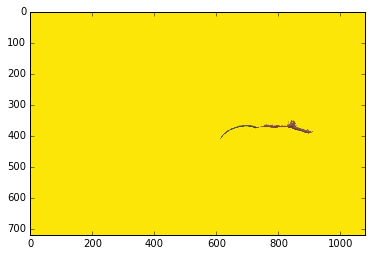

In [378]:
imshow(np.array(grass.filled()[:,:]*(1-total_diffs), dtype="uint8"))

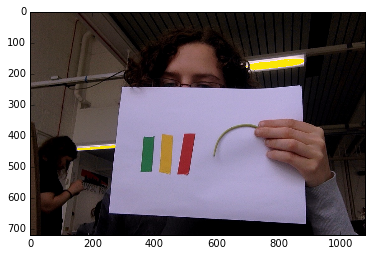

In [379]:
imshow(np.array(img[:,:]*(1-total_diffs), dtype="uint8"))